# Optimization Under Uncertainty - Homework 3
## Jeremy  Jornet 931215248
## Shani Pais 316517218

## Question 1

In [ ]:
import numpy as np
import cvxpy as cp
from typing import Tuple, Dict, Any

class RobustInventoryOptimizer:
    """
    Robust counterpart formulation for multi-stage inventory problem
    following the approach described in the mathematical document.
    """

    def __init__(self, T: int = 5, zeta_min: float = 100.0, zeta_max: float = 300.0):
        """
        Initialize the robust inventory optimizer.

        Args:
            T: Number of time periods (default 5)
            zeta_min: Lower bound for uncertainty set
            zeta_max: Upper bound for uncertainty set
        """
        self.T = T  # Number of periods
        self.zeta_min = zeta_min
        self.zeta_max = zeta_max

        # Problem parameters (can be customized)
        self.c = np.array([0.1, 0.1, 0.1, 0.1, 0.1])  # Ordering costs
        self.h = np.array([0.02, 0.02, 0.02, 0.02, 0.02])  # Holding costs
        self.b = np.array([0.2, 0.2, 0.2, 0.2, 2])  # Backlogging costs
        self.x_bar = 260.0  # Order limit
        self.initial_inventory = 0.0  # Initial stock level

        # Decision variables will be created in solve()
        self.x0 = None  # Constant terms for ordering policy
        self.X = None   # Coefficient matrix for ordering policy
        self.v0 = None  # Constant terms for auxiliary variables
        self.V = None   # Coefficient matrix for auxiliary variables
        self.rho = None # Epigraph variable for objective

        # Dual variables for robust counterpart
        self.dual_vars = {}

    def create_variables(self):
        """Create optimization variables for the robust counterpart."""
        # Ordering policy variables
        self.x0 = cp.Variable(self.T, nonneg=True, name="x0")  # x_t^0 for t=0,...,4

        # X matrix: lower triangular for non-anticipativity
        # X[t,s] = x_{t+1}^{s+1} (shifted indexing for implementation)
        self.X = cp.Variable((self.T, self.T), name="X")

        # Auxiliary cost variables
        self.v0 = cp.Variable(self.T, name="v0")  # v_t^0 for t=1,...,5
        self.V = cp.Variable((self.T, self.T), name="V")   # V[t,s] = v_{t+1}^{s+1}

        # Epigraph variable for objective
        self.rho = cp.Variable(name="rho")

        # Dual variables for robust counterpart reformulation
        self._create_dual_variables()

    def _create_dual_variables(self):
        """Create dual variables for robust counterpart constraints."""
        # Objective dual variables
        self.dual_vars['mu_obj'] = cp.Variable(self.T, nonneg=True, name="mu_obj")
        self.dual_vars['beta_obj'] = cp.Variable(self.T, nonneg=True, name="beta_obj")

        # Holding cost dual variables (for each time period)
        self.dual_vars['mu_h'] = [cp.Variable(self.T, nonneg=True, name=f"mu_h_{t}")
                                  for t in range(self.T)]
        self.dual_vars['beta_h'] = [cp.Variable(self.T, nonneg=True, name=f"beta_h_{t}")
                                    for t in range(self.T)]

        # Backlogging cost dual variables
        self.dual_vars['mu_b'] = [cp.Variable(self.T, nonneg=True, name=f"mu_b_{t}")
                                  for t in range(self.T)]
        self.dual_vars['beta_b'] = [cp.Variable(self.T, nonneg=True, name=f"beta_b_{t}")
                                    for t in range(self.T)]

        # Ordering limit dual variables (upper bound)
        self.dual_vars['mu_xbar'] = [cp.Variable(self.T, nonneg=True, name=f"mu_xbar_{t}")
                                     for t in range(self.T)]
        self.dual_vars['beta_xbar'] = [cp.Variable(self.T, nonneg=True, name=f"beta_xbar_{t}")
                                       for t in range(self.T)]

        # Ordering limit dual variables (lower bound)
        self.dual_vars['mu_0'] = [cp.Variable(self.T, nonneg=True, name=f"mu_0_{t}")
                                  for t in range(self.T)]
        self.dual_vars['beta_0'] = [cp.Variable(self.T, nonneg=True, name=f"beta_0_{t}")
                                    for t in range(self.T)]

    def create_constraints(self):
        """Create all constraints for the robust counterpart."""
        constraints = []

        # Non-anticipativity constraints (X matrix structure)
        # X[t,s] = 0 for s >= t (can only use demands ζ_1, ..., ζ_t when deciding at time t)
        # This creates: empty first row, zero main diagonal, empty last column
        for t in range(self.T):
            for s in range(t, self.T):
                constraints.append(self.X[t, s] == 0)

        # Robust counterpart constraints
        constraints.extend(self._objective_constraints())
        constraints.extend(self._holding_cost_constraints())
        constraints.extend(self._backlogging_cost_constraints())
        constraints.extend(self._ordering_limit_constraints())

        return constraints

    def _objective_constraints(self):
        """Robust counterpart constraints for the objective function."""
        constraints = []

        # Compute coefficient vector a_obj
        a_obj = cp.Variable(self.T, name="a_obj")

        for s in range(self.T):
            # a_obj[s] = sum_{t=s}^{4} c_t * x_t^s + sum_{t=1}^{5} v_t^s
            ordering_term = sum(self.c[t] * self.X[t, s] for t in range(s, self.T))
            auxiliary_term = sum(self.V[t, s] for t in range(self.T))
            constraints.append(a_obj[s] == ordering_term + auxiliary_term)

        # Dual constraint: a_obj = mu_obj - beta_obj
        constraints.append(a_obj == self.dual_vars['mu_obj'] - self.dual_vars['beta_obj'])

        # Epigraph constraint
        constant_cost = cp.sum(cp.multiply(self.c, self.x0)) + cp.sum(self.v0)
        dual_cost = self.zeta_max * cp.sum(self.dual_vars['mu_obj']) - \
                   self.zeta_min * cp.sum(self.dual_vars['beta_obj'])
        constraints.append(self.rho >= constant_cost + dual_cost)

        return constraints

    def _holding_cost_constraints(self):
        """Robust counterpart constraints for holding costs.

        Inventory at time t: sum_{p=0}^{t-1} x_p(ζ) - sum_{p=1}^{t} ζ_p
        (assumes initial inventory = 0)
        """
        constraints = []

        for t in range(self.T):  # t represents time periods 1,...,5
            # Compute coefficient vector a_h,t
            a_h_t = cp.Variable(self.T, name=f"a_h_{t}")

            for s in range(self.T):
                # a_h,t,s = h_t * sum_{p=s}^{t-1} x_p^s - h_t * 1_{s <= t} - v_t^s
                ordering_sum = sum(self.X[p, s] for p in range(s, t+1))
                indicator = 1.0 if s <= t else 0.0
                constraints.append(
                    a_h_t[s] == self.h[t] * ordering_sum - self.h[t] * indicator - self.V[t, s]
                )

            # Dual constraint
            constraints.append(
                a_h_t == self.dual_vars['mu_h'][t] - self.dual_vars['beta_h'][t]
            )

            # Main constraint
            constant_term = self.v0[t] - self.h[t] * cp.sum(self.x0[:t+1])
            dual_term = self.zeta_max * cp.sum(self.dual_vars['mu_h'][t]) - \
                       self.zeta_min * cp.sum(self.dual_vars['beta_h'][t])
            constraints.append(constant_term >= dual_term)

        return constraints

    def _backlogging_cost_constraints(self):
        """Robust counterpart constraints for backlogging costs.

        Inventory at time t: sum_{p=0}^{t-1} x_p(ζ) - sum_{p=1}^{t} ζ_p
        (assumes initial inventory = 0)
        """
        constraints = []

        for t in range(self.T):
            # Compute coefficient vector a_b,t
            a_b_t = cp.Variable(self.T, name=f"a_b_{t}")

            for s in range(self.T):
                # a_b,t,s = -b_t * sum_{p=s}^{t-1} x_p^s + b_t * 1_{s <= t} - v_t^s
                ordering_sum = sum(self.X[p, s] for p in range(s, t+1))
                indicator = 1.0 if s <= t else 0.0
                constraints.append(
                    a_b_t[s] == -self.b[t] * ordering_sum + self.b[t] * indicator - self.V[t, s]
                )

            # Dual constraint
            constraints.append(
                a_b_t == self.dual_vars['mu_b'][t] - self.dual_vars['beta_b'][t]
            )

            # Main constraint
            constant_term = self.v0[t] + self.b[t] * cp.sum(self.x0[:t+1])
            dual_term = self.zeta_max * cp.sum(self.dual_vars['mu_b'][t]) - \
                       self.zeta_min * cp.sum(self.dual_vars['beta_b'][t])
            constraints.append(constant_term >= dual_term)

        return constraints

    def _ordering_limit_constraints(self):
        """Robust counterpart constraints for ordering limits."""
        constraints = []

        for t in range(self.T):
            # Upper bound constraints: x_t(zeta) <= x_bar
            a_xbar_t = cp.Variable(self.T, name=f"a_xbar_{t}")

            for s in range(self.T):
                coeff = self.X[t, s] if s < t else 0
                constraints.append(a_xbar_t[s] == coeff)

            constraints.append(
                a_xbar_t == self.dual_vars['mu_xbar'][t] - self.dual_vars['beta_xbar'][t]
            )

            dual_term_upper = self.zeta_max * cp.sum(self.dual_vars['mu_xbar'][t]) - \
                             self.zeta_min * cp.sum(self.dual_vars['beta_xbar'][t])
            constraints.append(self.x_bar - self.x0[t] >= dual_term_upper)

            # Lower bound constraints: x_t(zeta) >= 0
            a_0_t = cp.Variable(self.T, name=f"a_0_{t}")

            for s in range(self.T):
                coeff = -self.X[t, s] if s < t else 0
                constraints.append(a_0_t[s] == coeff)

            constraints.append(
                a_0_t == self.dual_vars['mu_0'][t] - self.dual_vars['beta_0'][t]
            )

            dual_term_lower = self.zeta_max * cp.sum(self.dual_vars['mu_0'][t]) - \
                             self.zeta_min * cp.sum(self.dual_vars['beta_0'][t])
            constraints.append(self.x0[t] >= dual_term_lower)  # x_t(zeta) >= 0 for all zeta

        return constraints

    def solve(self, solver=cp.CLARABEL, verbose=True) -> Dict[str, Any]:
        """
        Solve the robust inventory optimization problem.

        Args:
            solver: CVXPY solver to use
            verbose: Whether to print solver output

        Returns:
            Dictionary containing solution and results
        """
        # Create variables and constraints
        self.create_variables()
        constraints = self.create_constraints()

        # Define objective
        objective = cp.Minimize(self.rho)

        # Create and solve problem
        problem = cp.Problem(objective, constraints)

        try:
            problem.solve(solver=solver, verbose=verbose)

            if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                return self._extract_solution()
            else:
                return {"status": problem.status, "optimal_value": None}

        except Exception as e:
            print(f"Solver error: {e}")
            return {"status": "ERROR", "error": str(e)}

    def _extract_solution(self) -> Dict[str, Any]:
        """Extract solution from solved problem."""
        return {
            "status": "OPTIMAL",
            "optimal_value": self.rho.value,
            "x0": self.x0.value,
            "X": self.X.value,
            "v0": self.v0.value,
            "V": self.V.value,
            "ordering_costs": self.c,
            "holding_costs": self.h,
            "backlogging_costs": self.b,
            "order_limit": self.x_bar,
            "uncertainty_bounds": (self.zeta_min, self.zeta_max)
        }

    def print_solution(self, solution: Dict[str, Any]):
        """Print the solution in a formatted way."""
        if solution["status"] != "OPTIMAL":
            print(f"Solution status: {solution['status']}")
            return

        print("ROBUST INVENTORY OPTIMIZATION SOLUTION")
        print("=" * 50)
        print(f"Optimal worst-case cost: {solution['optimal_value']:.2f}")
        print(f"Initial inventory: {self.initial_inventory}")
        print("Inventory Dynamics:")
        print(f"Initial inventory: {self.initial_inventory}")
        print("Inventory at time t = Σ(orders 0 to t-1) - Σ(demands 1 to t)")
        print("Holding cost when inventory ≥ 0, backlog cost when inventory < 0")
        print()

        print("Ordering Policy Coefficients:")
        print("x₀ (constant terms):")
        for t, val in enumerate(solution["x0"]):
            print(f"  x₀[{t}] = {val:8.3f}")
        print()

        print("X Matrix (demand-responsive coefficients):")
        print("Rows = time periods, Columns = demand periods")
        X = solution["X"]
        print("      ", end="")
        for s in range(self.T):
            print(f"    ζ{s+1}", end="")
        print()

        for t in range(self.T):
            print(f"t={t}: ", end="")
            for s in range(self.T):
                print(f"{X[t,s]:7.3f}", end="")
            print()
        print()

        print("Auxiliary Variables:")
        print("v₀ (constant terms):")
        for t, val in enumerate(solution["v0"]):
            print(f"  v₀[{t}] = {val:8.3f}")
        print()

        print("V Matrix (auxiliary coefficients):")
        print("Rows = time periods, Columns = demand periods")
        V = solution["V"]
        print("      ", end="")
        for s in range(self.T):
            print(f"    ζ{s+1}", end="")
        print()

        for t in range(self.T):
            print(f"t={t}: ", end="")
            for s in range(self.T):
                print(f"{V[t,s]:7.3f}", end="")
            print()
        print()

        print("Linear Decision Rules:")
        print("Order quantities as functions of observed demands:")
        for t in range(self.T):
            terms = [f"{solution['x0'][t]:.3f}"]
            for s in range(t):  # Only use s < t due to non-anticipativity
                if abs(X[t,s]) > 1e-6:
                    sign = "+" if X[t,s] >= 0 else "-"
                    terms.append(f"{sign}{abs(X[t,s]):.3f}*ζ{s+1}")
            print(f"  x{t}(ζ) = {' '.join(terms)}")


def run_optimization():
    """Run the robust inventory optimization and display results."""
    print("Robust Multi-Stage Inventory Optimization")
    print("=" * 50)

    # Initialize optimizer
    optimizer = RobustInventoryOptimizer()

    print("Problem Parameters:")
    print(f"Time periods: {optimizer.T}")
    print(f"Initial inventory: {optimizer.initial_inventory}")
    print(f"Ordering costs: {optimizer.c}")
    print(f"Holding costs: {optimizer.h}")
    print(f"Backlogging costs: {optimizer.b}")
    print(f"Order limit: {optimizer.x_bar}")
    print(f"Uncertainty set: [{optimizer.zeta_min}, {optimizer.zeta_max}]")
    print()

    # Solve the problem
    print("Solving robust counterpart...")
    solution = optimizer.solve(verbose=False)

    # Print detailed solution
    optimizer.print_solution(solution)

    return optimizer, solution


if __name__ == "__main__":
    optimizer, solution = run_optimization()

Robust Multi-Stage Inventory Optimization
Problem Parameters:
Time periods: 5
Initial inventory: 0.0
Ordering costs: [0.1 0.1 0.1 0.1 0.1]
Holding costs: [0.02 0.02 0.02 0.02 0.02]
Backlogging costs: [0.2 0.2 0.2 0.2 2. ]
Order limit: 260.0
Uncertainty set: [100.0, 300.0]

Solving robust counterpart...
ROBUST INVENTORY OPTIMIZATION SOLUTION
Optimal worst-case cost: 610.00
Initial inventory: 0.0
Inventory Dynamics:
Initial inventory: 0.0
Inventory at time t = Σ(orders 0 to t-1) - Σ(demands 1 to t)
Holding cost when inventory ≥ 0, backlog cost when inventory < 0

Ordering Policy Coefficients:
x₀ (constant terms):
  x₀[0] =  260.000
  x₀[1] =  135.666
  x₀[2] =   94.827
  x₀[3] =   54.643
  x₀[4] =   34.660

X Matrix (demand-responsive coefficients):
Rows = time periods, Columns = demand periods
          ζ1    ζ2    ζ3    ζ4    ζ5
t=0:   0.000  0.000  0.000  0.000  0.000
t=1:   0.414 -0.000  0.000  0.000  0.000
t=2:   0.157  0.393 -0.000  0.000  0.000
t=3:   0.107  0.182  0.395 -0.000  0

# Question 2.

In [ ]:
# Install MOSEK and CVXPY with MOSEK support
!pip install -q mosek
!pip install -q 'cvxpy[mosek]'

# Move the license to the default path expected by MOSEK (/root/mosek/mosek.lic)
import os
import shutil

# Create the target directory and move the license
mosek_dir = '/root/mosek'
os.makedirs(mosek_dir, exist_ok=True)
shutil.copy('/content/mosek.lic', os.path.join(mosek_dir, 'mosek.lic'))

# Check it worked
print("✅ License moved to /root/mosek/")

import cvxpy as cp

# Simple problem to test MOSEK
x = cp.Variable()
objective = cp.Minimize((x - 3)**2)
constraints = [x >= 0]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)

print(f"✅ MOSEK is working: x = {x.value:.2f}, objective = {prob.value:.2f}")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 119.8 MB/s eta 0:00:00
✅ License moved to /root/mosek/
✅ MOSEK is working: x = 3.00, objective = 0.00


In [ ]:
!pip install ecos --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.1 which is incompati

In [ ]:
import ecos
import cvxpy as cp
print(cp.installed_solvers())


['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'HIGHS', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


## Part A

In [ ]:
import numpy as np
import cvxpy as cp
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def simulate_demand_samples(numSamples: int, numPeriods: int, xi_min=-20, xi_max=20):
    """
    Generate synthetic demand scenarios using correlated uniform shocks.
    """
    xi = np.random.uniform(xi_min, xi_max, size=(numSamples, numPeriods))
    zeta = []
    for n in range(numSamples):
        sample = []
        for t in range(numPeriods):
            shock_sum = 0.5 * np.sum(xi[n, :t]) if t > 0 else 0
            demand = 200 + shock_sum + xi[n, t]
            sample.append(demand)
        zeta.append(tuple(sample))
    return zeta

def solve_saa_policy_model(
    holdingCost, backlogCostVec, productionCostVec,
    maxProduction, demandSamples
):
    """
    Solves the SAA inventory problem using scenario-wise decisions
    with explicit non-anticipativity constraints.
    """
    zeta = np.array(demandSamples).T  # shape (T, N)
    T, N = zeta.shape

    # Decision variables
    x = cp.Variable((T, N))  # order quantity
    y = cp.Variable((T, N))  # inventory
    v = cp.Variable((T, N))  # auxiliary for cost

    h_vec = np.full((T, 1), holdingCost)
    b_vec = np.array(backlogCostVec).reshape((T, 1))
    c_vec = np.array(productionCostVec).reshape((T, 1))

    constraints = []

    # Inventory balance
    for t in range(T):
        cum_x = cp.sum(x[0:t+1, :], axis=0)
        cum_demand = np.sum(zeta[0:t+1, :], axis=0)
        constraints.append(y[t, :] == cum_x - cum_demand)

    # Cost bounds
    constraints.append(v >= cp.multiply(h_vec, y))
    constraints.append(v >= -cp.multiply(b_vec, y))

    # Feasibility bounds
    constraints.append(x >= 0)
    constraints.append(x <= maxProduction)

    # Non-anticipativity constraints
    def demand_history_key(s, t):
        return tuple(np.round(s[:t+1], decimals=6))

    zeta_TN = zeta.T  # (N, T)

    for t in range(T):
        groups = defaultdict(list)
        for n in range(N):
            key = demand_history_key(zeta_TN[n], t)
            groups[key].append(n)
        for group in groups.values():
            if len(group) > 1:
                ref = group[0]
                for n in group[1:]:
                    constraints.append(x[t, ref] == x[t, n])

    # Objective function
    total_cost = cp.sum(cp.multiply(c_vec, x)) + cp.sum(v)
    objective = cp.Minimize(total_cost / N)

    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.ECOS, verbose=False)
        if problem.status in ["infeasible", "unbounded"]:
            return {"objectiveValue": None, "x0": None, "status": problem.status}
        return {
            "objectiveValue": problem.value,
            "x0": x.value[0, 0],
            "status": problem.status
        }
    except Exception as e:
        print(f"Solver error: {e}")
        return {"objectiveValue": None, "x0": None, "status": "error"}


def main():
    # Experiment settings
    NUM_EXPERIMENTS = 10
    N_SCENARIOS = 10000
    T_PERIODS = 5

    # Costs
    h_costs = [0.02] * T_PERIODS
    b_costs = [0.2, 0.2, 0.2, 0.2, 2.0]
    c_costs = [0.1] * T_PERIODS
    x_max_order = 260.0

    results = []

    print("\n🔁 Starting Simulation\n")
    print(f"Running {NUM_EXPERIMENTS} experiments with {N_SCENARIOS} scenarios each.\n")

    # Table Header
    print("┌────────────┬──────────────┬────────────────────┬────────────────────┐")
    print("│ Experiment │     Status   │  Objective Value   │  Order at time t=0 │")
    print("├────────────┼──────────────┼────────────────────┼────────────────────┤")

    for i in range(NUM_EXPERIMENTS):
        samples = simulate_demand_samples(N_SCENARIOS, T_PERIODS)
        result = solve_saa_policy_model(
            holdingCost=0.02,
            backlogCostVec=b_costs,
            productionCostVec=c_costs,
            maxProduction=x_max_order,
            demandSamples=samples
        )

        if result["objectiveValue"] is not None:
            status = " Success"
            obj_val = f"{result['objectiveValue']:.4f}"
            x0_val = f"{result['x0']:.4f}"
        else:
            status = " Failed"
            obj_val = "–"
            x0_val = "–"

        print(f"│     {i+1:<5}  │ {status:<12} │ {obj_val:^18} │ {x0_val:^18} │")

        results.append(result)

    print("└────────────┴──────────────┴────────────────────┴────────────────────┘")

    # Final Summary
    feasible = [r for r in results if r["objectiveValue"] is not None]
    print("\n📈 Summary Statistics\n")

    if feasible:
        mean_obj = np.mean([r["objectiveValue"] for r in feasible])
        std_obj = np.std([r["objectiveValue"] for r in feasible])
        mean_x0 = np.mean([r["x0"] for r in feasible])
        std_x0 = np.std([r["x0"] for r in feasible])


        print(f"✔️  Feasible runs        : {len(feasible)} / {NUM_EXPERIMENTS}")

        print()
        print("Objective Value")
        print(f"📉 Mean objective value  : {mean_obj:.4f}")
        print(f"📊 Std. deviation        : {std_obj:.4f}")
        print()

        print("Order at x=0")
        print(f"📦 Mean order at t=0     : {mean_x0:.4f}")
        print(f"📦 Std. deviation x₀     : {std_x0:.4f}")
    else:
        print("⚠️  No feasible runs. Statistics unavailable.")


if __name__ == "__main__":
    main()



🔁 Starting Simulation

Running 10 experiments with 10000 scenarios each.

┌────────────┬──────────────┬────────────────────┬────────────────────┐
│ Experiment │     Status   │  Objective Value   │  Order at time t=0 │
├────────────┼──────────────┼────────────────────┼────────────────────┤
│     1      │  Success     │      99.9433       │      191.1294      │
│     2      │  Success     │      100.0310      │      184.3815      │
│     3      │  Success     │      100.0568      │      215.1399      │
│     4      │  Success     │      99.9889       │      189.9560      │
│     5      │  Success     │      100.0200      │      181.8325      │
│     6      │  Success     │      100.0175      │      205.3454      │
│     7      │  Success     │      100.0204      │      183.6106      │
│     8      │  Success     │      99.8986       │      214.9409      │
│     9      │  Success     │      99.9899       │      203.3050      │
│     10     │  Success     │      100.0694      │      191.3

## Part B

In [ ]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def generate_scenario_tree(branching_factor, depth, global_seed=None, xi_min=-20, xi_max=20):
    """
    Generates a full scenario tree with branching_factor^depth scenarios.
    Each path is a unique demand vector (tuple of T values).
    """
    num_scenarios = branching_factor ** depth
    demand_scenarios = []
    rng = np.random.default_rng(global_seed)

    for path_id in range(num_scenarios):
        node = path_id
        shocks = []
        for t in range(depth):
            branch = node % branching_factor
            node //= branching_factor
            local_seed = rng.integers(0, 1_000_000)
            local_rng = np.random.default_rng(local_seed)
            shock = local_rng.uniform(xi_min, xi_max)
            shocks.insert(0, shock)
        demand = []
        for t in range(depth):
            history_sum = 0.5 * sum(shocks[:t])
            demand_t = 200 + history_sum + shocks[t]
            demand.append(demand_t)
        demand_scenarios.append(tuple(demand))

    return demand_scenarios


def solve_saa_with_tree_nonanticipativity(
    holdingCost, backlogCostVec, productionCostVec,
    maxProduction, demandSamples
):
    """
    Solves the SAA inventory model using tree-structured non-anticipativity constraints.
    """
    zeta = np.array(demandSamples).T  # shape (T, N)
    T, N = zeta.shape

    x = cp.Variable((T, N))
    y = cp.Variable((T, N))
    v = cp.Variable((T, N))

    h_vec = np.full((T, 1), holdingCost)
    b_vec = np.array(backlogCostVec).reshape((T, 1))
    c_vec = np.array(productionCostVec).reshape((T, 1))

    constraints = []

    for t in range(T):
        cum_x = cp.sum(x[0:t+1, :], axis=0)
        cum_d = np.sum(zeta[0:t+1, :], axis=0)
        constraints.append(y[t, :] == cum_x - cum_d)

    constraints.append(v >= cp.multiply(h_vec, y))
    constraints.append(v >= -cp.multiply(b_vec, y))
    constraints.append(x >= 0)
    constraints.append(x <= maxProduction)

    def demand_history_key(scenario, t):
        return tuple(np.round(scenario[:t+1], 5))

    zeta_TN = zeta.T

    for t in range(T):
        groups = defaultdict(list)
        for n in range(N):
            key = demand_history_key(zeta_TN[n], t)
            groups[key].append(n)
        for group in groups.values():
            rep = group[0]
            for n in group[1:]:
                constraints.append(x[t, rep] == x[t, n])

    total_cost = cp.sum(cp.multiply(c_vec, x)) + cp.sum(v)
    objective = cp.Minimize(total_cost / N)

    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.ECOS, verbose=False)
        if problem.status in ["infeasible", "unbounded"]:
            return {"objective": None, "x0": None, "status": problem.status}
        return {"objective": problem.value, "x0": x.value[0, 0], "status": problem.status}
    except Exception as e:
        print(f"Solver error: {e}")
        return {"objective": None, "x0": None, "status": "error"}


def main():
    NUM_EXPERIMENTS = 10
    BRANCHING = 8
    T_PERIODS = 5
    N_SCENARIOS = BRANCHING ** T_PERIODS

    h_costs = [0.02] * T_PERIODS
    b_costs = [0.2, 0.2, 0.2, 0.2, 2.0]
    c_costs = [0.1] * T_PERIODS
    x_max = 260.0

    results = []

    print("\n Running SAA with 8-way scenario tree")
    print(f"Each tree has {N_SCENARIOS} scenarios (T = {T_PERIODS})\n")
    print("┌────────────┬──────────────┬────────────────────┬────────────────────┐")
    print("│ Experiment │     Status   │  Objective Value   │  Order at time t=0 │")
    print("├────────────┼──────────────┼────────────────────┼────────────────────┤")

    for i in range(NUM_EXPERIMENTS):
        samples = generate_scenario_tree(BRANCHING, T_PERIODS, global_seed=i)
        result = solve_saa_with_tree_nonanticipativity(
            holdingCost=0.02,
            backlogCostVec=b_costs,
            productionCostVec=c_costs,
            maxProduction=x_max,
            demandSamples=samples
        )
        if result["objective"] is not None:
            status = "  Success"
            obj = f"{result['objective']:.4f}"
            x0 = f"{result['x0']:.4f}"
        else:
            status = "  Failed"
            obj = "–"
            x0 = "–"
        print(f"│     {i+1:<5}  │ {status:<12} │ {obj:^18} │ {x0:^18} │")
        results.append(result)

    print("└────────────┴──────────────┴────────────────────┴────────────────────┘")

    feasible = [r for r in results if r["objective"] is not None]
    print("\n📈 Summary Statistics")
    if feasible:
        print(f"Feasible runs       : {len(feasible)} / {NUM_EXPERIMENTS}")

        print()
        print(f"Average cost        : {np.mean([r['objective'] for r in feasible]):.4f}")
        print(f"Std. dev. of cost   : {np.std([r['objective'] for r in feasible]):.4f}")

        print()
        print(f"Average x₀          : {np.mean([r['x0'] for r in feasible]):.4f}")
        print(f"Std. dev. of x₀     : {np.std([r['x0'] for r in feasible]):.4f}")
    else:
        print("⚠️ No feasible solutions found.")

if __name__ == "__main__":
    main()



 Running SAA with 8-way scenario tree
Each tree has 32768 scenarios (T = 5)

┌────────────┬──────────────┬────────────────────┬────────────────────┐
│ Experiment │     Status   │  Objective Value   │  Order at time t=0 │
├────────────┼──────────────┼────────────────────┼────────────────────┤
│     1      │   Success    │      99.9797       │      209.1615      │
│     2      │   Success    │      100.0400      │      200.6337      │
│     3      │   Success    │      100.0175      │      213.0190      │
│     4      │   Success    │      100.0249      │      194.1734      │
│     5      │   Success    │      100.0098      │      190.1725      │
│     6      │   Success    │      99.9971       │      186.0493      │
│     7      │   Success    │      100.0081      │      214.2123      │
│     8      │   Success    │      100.0738      │      211.7024      │
│     9      │   Success    │      100.0481      │      207.8433      │
│     10     │   Success    │      100.0465      │      19

## PART C

In [ ]:
!pip install -q mosek
!pip install -q 'cvxpy[mosek]' --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.8 MB/s eta 0:00:00


In [ ]:
import os, shutil

os.makedirs("/root/mosek", exist_ok=True)
shutil.copy("/content/mosek.lic", "/root/mosek/mosek.lic")
print("✅ Licence déplacée dans /root/mosek/mosek.lic")


✅ Licence déplacée dans /root/mosek/mosek.lic


Running ε=0.0 on full dataset...
ε=0.0 optimal cost on full data : 120.10

Performing cross-validation for other ε>0 values...
ε=0.1 average validation cost: 121.11
ε=0.6 average validation cost: 121.42
ε=1.1 average validation cost: 121.61
ε=1.6 average validation cost: 121.89
ε=2.1 average validation cost: 122.29
ε=2.6 average validation cost: 122.50
ε=3.1 average validation cost: 122.73
ε=3.7 average validation cost: 122.96
ε=4.2 average validation cost: 123.13
ε=4.7 average validation cost: 123.32
ε=5.2 average validation cost: 123.52
ε=5.7 average validation cost: 123.72
ε=6.2 average validation cost: 123.86
ε=6.7 average validation cost: 124.00
ε=7.2 average validation cost: 124.13
ε=7.7 average validation cost: 124.27
ε=8.2 average validation cost: 124.48
ε=8.7 average validation cost: 124.68
ε=9.2 average validation cost: 124.87
ε=9.8 average validation cost: 125.03
ε=10.3 average validation cost: 125.18
ε=10.8 average validation cost: 125.32
ε=11.3 average validation cost: 125

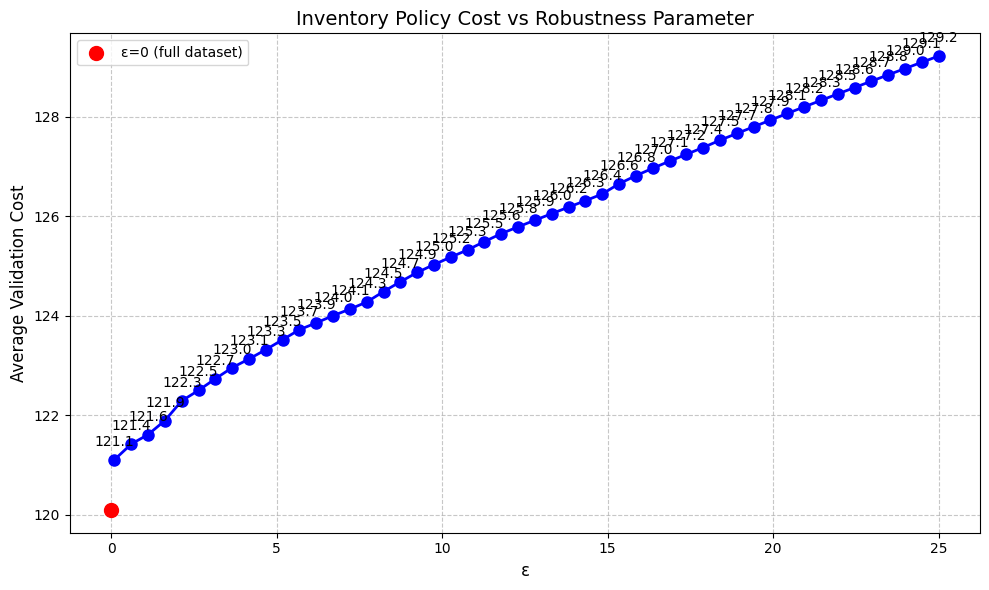

In [ ]:
import numpy as np
import cvxpy as cp
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# I tried to stick to the SRO Reformulation from Tirgul 6,
# with W₁ balls, linear inner problems dualized via SOC constraints.

# Disable solver output and warnings
warnings.filterwarnings("ignore", category=UserWarning)

class InventoryOptimizer:
    def __init__(self):
        self.config = self._initialize_parameters()
        np.random.seed(248)  # For reproducible results - Last 3 digits of my TZ

    def _initialize_parameters(self):
        """Initialize system configuration parameters"""
        params = {
            'time_periods': 5,
            'scenario_count': 100,
            'holding_costs': np.full(5, 0.02),
            'shortage_costs': np.array([0.2, 0.2, 0.2, 0.2, 2.0]),
            'order_costs': np.full(5, 0.1),
            'max_order_qty': 260.0,
            'initial_inventory': 0.0
        }

        T = params['time_periods']
        h = params['holding_costs']
        b = params['shortage_costs']

        H = np.zeros((T, T))
        B = np.zeros((T, T))
        for i in range(T):
            for j in range(i + 1):
                H[i, j] = h[i]
                B[i, j] = b[i]

        params['H_matrix'] = H
        params['B_matrix'] = B
        return params

    def solve_optimization(self, demands, epsilon):
        """Solve the robust optimization problem"""
        N, T = demands.shape
        cfg = self.config
        c, h, b = cfg['order_costs'], cfg['holding_costs'], cfg['shortage_costs']
        H, B = cfg['H_matrix'], cfg['B_matrix']
        max_order = cfg['max_order_qty']
        y0 = cfg['initial_inventory']

        # Decision variables
        x0 = cp.Variable(T, name="base_orders")
        v0 = cp.Variable(T, name="buffer_vars")
        X = cp.Variable((T, T), name="response_matrix")
        V = cp.Variable((T, T), name="adjustment_matrix")
        rho = cp.Variable(name="total_cost")

        # Dual variables
        lam_obj = cp.Variable(N, nonneg=True)
        lam_h = cp.Variable((T, N), nonneg=True)
        lam_b = cp.Variable((T, N), nonneg=True)
        lam_x = cp.Variable((T, N), nonneg=True)
        mu_obj = cp.Variable((N, T), nonneg=True)
        mu_h = cp.Variable((T, N, T), nonneg=True)
        mu_b = cp.Variable((T, N, T), nonneg=True)
        mu_x = cp.Variable((T, N, T), nonneg=True)
        beta_obj = cp.Variable((N, T), nonneg=True)
        beta_h = cp.Variable((T, N, T), nonneg=True)
        beta_b = cp.Variable((T, N, T), nonneg=True)
        beta_x = cp.Variable((T, N, T), nonneg=True)

        # Problem constraints
        constraints = [X[t, s] == 0 for t in range(T) for s in range(t + 1, T)]
        constraints += [v0 >= 0]

        # Objective components
        a_obj = c @ X + np.ones(T) @ V
        scenario_terms = []

        for i in range(N):
            d = demands[i, :]
            term = (a_obj @ d + lam_obj[i] * epsilon -
                   (100*mu_obj[i,:] - 300*beta_obj[i,:]) @ np.ones(T) -
                   (beta_obj[i,:] - mu_obj[i,:]) @ d)
            scenario_terms.append(term)
            constraints.append(cp.SOC(lam_obj[i], -a_obj - mu_obj[i,:] + beta_obj[i,:]))

        obj_sum = cp.sum(scenario_terms)
        constraints.append(rho == cp.sum(c * x0) + cp.sum(v0) + (1/N) * obj_sum)

        # Time period constraints
        for t in range(T):
            e_t = np.eye(T)[t]
            sum_vec = np.sum([np.eye(T)[s] for s in range(t + 1)], axis=0)
            y_pos = y0 + (cp.sum(x0[:t]) if t > 0 else 0)

            for i in range(N):
                d = demands[i,:]

                # Holding constraints
                a_h = -(V.T + H.T) @ e_t + h[t] * X.T @ sum_vec
                f_h = (a_h @ d + lam_h[t,i]*epsilon -
                      (100*mu_h[t,i,:]-300*beta_h[t,i,:])@np.ones(T) -
                      (beta_h[t,i,:]-mu_h[t,i,:])@d)
                constraints.append(f_h <= v0[t] - h[t]*y_pos)
                constraints.append(cp.SOC(lam_h[t,i], -a_h-mu_h[t,i,:]+beta_h[t,i,:]))

                # Shortage constraints
                a_b = (-V.T + B.T)@e_t - b[t]*X.T@sum_vec
                f_b = (a_b @ d + lam_b[t,i]*epsilon -
                      (100*mu_b[t,i,:]-300*beta_b[t,i,:])@np.ones(T) -
                      (beta_b[t,i,:]-mu_b[t,i,:])@d)
                constraints.append(f_b <= v0[t] + b[t]*y_pos)
                constraints.append(cp.SOC(lam_b[t,i], -a_b-mu_b[t,i,:]+beta_b[t,i,:]))

                # Order constraints
                a_x = X.T@sum_vec
                f_x = (a_x @ d + lam_x[t,i]*epsilon -
                      (100*mu_x[t,i,:]-300*beta_x[t,i,:])@np.ones(T) -
                      (beta_x[t,i,:]-mu_x[t,i,:])@d)
                constraints.append(f_x <= max_order - x0[t])
                constraints.append(cp.SOC(lam_x[t,i], -a_x-mu_x[t,i,:]+beta_x[t,i,:]))

        constraints += [x0 >= 0, x0 <= max_order]

        # Solve problem
        problem = cp.Problem(cp.Minimize(rho), constraints)
        try:
            problem.solve(solver=cp.MOSEK, verbose=False)
            if problem.status in ["optimal", "optimal_inaccurate"]:
                return {
                    "base_orders": x0.value,
                    "response_matrix": X.value,
                    "status": problem.status
                }
        except cp.error.SolverError:
            pass
        return {"status": "SolverError"}

    def generate_scenarios(self):
        """Generate demand scenarios for simulation"""
        N, T = self.config['scenario_count'], self.config['time_periods']
        shocks = np.random.uniform(-20, 20, size=(N, T))
        demands = np.zeros((N, T))

        for i in range(N):
            for t in range(T):
                demands[i, t] = 200 + 0.5 * np.sum(shocks[i, :t]) + shocks[i, t]
        return demands

    def evaluate_policy(self, policy, scenarios):
        """Evaluate policy performance on given scenarios"""
        T = self.config['time_periods']
        c, h, b = self.config['order_costs'], self.config['holding_costs'], self.config['shortage_costs']
        y0 = self.config['initial_inventory']

        x0 = policy['base_orders']
        X = policy['response_matrix']

        total_cost = 0
        for scenario in scenarios:
            scenario_cost = 0
            orders, inventory = np.zeros(T), np.zeros(T)

            for t in range(T):
                orders[t] = x0[t] + X[t, :] @ scenario
                scenario_cost += c[t] * orders[t]

            for t in range(T):
                inventory[t] = y0 + np.sum(orders[:t+1]) - np.sum(scenario[:t+1])
                scenario_cost += h[t] * inventory[t] if inventory[t] >= 0 else -b[t] * inventory[t]

            total_cost += scenario_cost

        return total_cost / len(scenarios)

    def run_analysis(self):
        """Execute complete analysis workflow"""
        demands = self.generate_scenarios()

        # 50 values from 0.1 to 25 inclusive
        epsilon_values = np.linspace(0.1, 25.0, 50).tolist()


        # First handle epsilon=0 case on full dataset
        print("Running ε=0.0 on full dataset...")
        epsilon0_policy = self.solve_optimization(demands, 0.0)
        if epsilon0_policy['status'] in ["optimal", "optimal_inaccurate"]:
            epsilon0_cost = self.evaluate_policy(epsilon0_policy, demands)
            print(f"ε=0.0 optimal cost on full data : {epsilon0_cost:.2f}")
        else:
            epsilon0_cost = np.inf
            print("Solver failed for ε=0.0")

        # Then perform cross-validation for other epsilons
        print("\nPerforming cross-validation for other ε>0 values...")
        kf = KFold(n_splits=5, shuffle=True, random_state=248)
        epsilon_costs = []

        for eps in epsilon_values:
            fold_costs = []

            for train_idx, test_idx in kf.split(demands):
                train_data = demands[train_idx]
                test_data = demands[test_idx]

                policy = self.solve_optimization(train_data, eps)

                if policy['status'] in ["optimal", "optimal_inaccurate"]:
                    test_cost = self.evaluate_policy(policy, test_data)
                    fold_costs.append(test_cost)

            if fold_costs:
                avg_cost = np.mean(fold_costs)
                epsilon_costs.append(avg_cost)
                print(f"ε={eps:.1f} average validation cost: {avg_cost:.2f}")
            else:
                epsilon_costs.append(np.inf)
                print(f"ε={eps:.1f}: All folds failed")

        # Prepare data for plotting
        all_epsilons = epsilon_values
        all_costs = epsilon_costs

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(all_epsilons, all_costs, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('ε', fontsize=12)
        plt.ylabel('Average Validation Cost', fontsize=12)
        plt.title('Inventory Policy Cost vs Robustness Parameter', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Highlight the epsilon=0 point since it's different
        plt.scatter([0], [epsilon0_cost], color='red', s=100, zorder=5,
                   label='ε=0 (full dataset)')

        # Annotate points with their values
        for eps, cost in zip(all_epsilons, all_costs):
            plt.annotate(f'{cost:.1f}', (eps, cost), textcoords="offset points",
                       xytext=(0,10), ha='center', fontsize=10)

        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    analyzer = InventoryOptimizer()
    analyzer.run_analysis()

In [ ]:
chosen_epsilon = 10.3
print(f"\n Now on full dataset with ε = {chosen_epsilon}...")

demands = analyzer.generate_scenarios()
final_policy = analyzer.solve_optimization(demands, chosen_epsilon)

if final_policy['status'] in ["optimal", "optimal_inaccurate"]:
    final_cost = analyzer.evaluate_policy(final_policy, demands)
    print(f" Final optimal cost on full data (ε={chosen_epsilon}): {final_cost:.2f}")
else:
    print(f" Solver failed for ε = {chosen_epsilon}")



 Now on full dataset with ε = 10.3...
 Final optimal cost on full data (ε=10.3): 121.09
